# Correcting ABT from Homework 5
Loading in the merged table and this first section will be where the features are updated
Will save to CSV at the end of this section and will read back in at the start of Homework 6

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

In [2]:
#Reading in Data and Combining Data Frames: Focus should be on click data when developing Features
clicks = pd.read_csv('click_sep.csv', low_memory=False)
buys = pd.read_csv('buy_sep.csv',low_memory=False)

print(clicks.head())
print(buys.head())

   SessionID                         TimeStamp     ItemID Category
0    9293568  2014-09-01 18:07:00.855000+00:00  214853225        S
1    9293653  2014-09-01 10:38:47.087000+00:00  214834871        S
2    9293653  2014-09-01 10:39:49.115000+00:00  214849327        S
3    9293653  2014-09-01 10:40:31.736000+00:00  214828970        S
4    9293653  2014-09-01 10:41:01.640000+00:00  214849327        S
   SessionID                         TimeStamp     ItemID  Price  Quantity
0    9641594  2014-09-01 09:09:25.575000+00:00  214853342   2093         2
1    9641594  2014-09-01 09:09:25.596000+00:00  214853340    837         2
2    9641594  2014-09-01 09:09:25.614000+00:00  214853420   1046         2
3    9431393  2014-09-01 13:38:48.351000+00:00  214846258    941         1
4    9431393  2014-09-01 13:38:48.414000+00:00  214853340    837         1


In [3]:
clicks['TimeStamp']=pd.to_datetime(clicks['TimeStamp'])

In [4]:
#Click Based Features - Previous Homework 5 Features
#Most Clicked on Item - Removing since encoding all items would reduce model performance
#feature0 = (clicks.groupby(['SessionID','ItemID'])['ItemID'].agg(['count']).sort_values(by='count', ascending=False).reset_index().drop_duplicates('ItemID', keep='first'))
#feature0 = feature0[["SessionID","ItemID"]]

#Which part of the day was the click #Would need to encode in order to leverage for Machine Learning
clicks['Hour']=clicks['TimeStamp'].dt.hour
clicks['TimeofDay']=clicks['Hour'].apply(lambda x: 'Morning' if 6<=x<12 else ('Afternoon' if 12<=x<18 else ('Evening' if 18<=x<24 else 'Night')))
feature1 = clicks.drop_duplicates(["SessionID", "TimeofDay"])
feature1 = feature1[["SessionID", "TimeofDay"]]

#Number of different categories of items which were clicked during each session how many different item categories were viewed during each click session?)
feature2 = clicks.groupby('SessionID')['Category'].nunique().reset_index(name="UniqueCategory")

#Number of Unique Items Clicked
feature3 = clicks.groupby('SessionID')['ItemID'].nunique().reset_index(name="ItemsFromSession")

#Max number of clicks on one item per session (In each session, let's identify how many times at maximum one of items was clicked)
feature4 = clicks.groupby('SessionID')['ItemID'].count().max(level=0).reset_index(name="MaxClicksFromSession")

#Day of Click - Will not use since using first click day and last click day
#clicks['DayofWeek']=clicks['TimeStamp'].dt.day_name() 
#feature5 = clicks.drop_duplicates(["SessionID", "DayofWeek"])
#feature5 = feature5[["SessionID", "DayofWeek"]]

#Weekend or Weekday
clicks['Day'] = pd.DatetimeIndex(clicks['TimeStamp']).dayofweek  
clicks['DayType']=clicks['Day'].apply(lambda x: 0 if 0<=x<5 else 1)
feature6 = clicks.groupby('SessionID')['DayType'].sum().reset_index(name="IsWeekend")
feature6['IsWeekend'] = feature6['IsWeekend'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
features = pd.merge(feature1, feature2, how='left',on='SessionID')
features.head()

,SessionID,TimeofDay,UniqueCategory
0,9293568,Evening,1
1,9293653,Morning,2
2,9293662,Morning,1
3,9293704,Evening,1
4,9293797,Afternoon,1


In [6]:
features = pd.merge(features, feature3, how='left',on='SessionID')
features = pd.merge(features, feature4, how='left',on='SessionID')
#features = pd.merge(features, feature5, how='left',on='SessionID')
features = pd.merge(features, feature6, how='left',on='SessionID')
features.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend
0,9293568,Evening,1,1,1,0
1,9293653,Morning,2,4,5,0
2,9293662,Morning,1,1,2,0
3,9293704,Evening,1,1,2,0
4,9293797,Afternoon,1,4,4,0


In [7]:
clicks['First_TS'] = clicks.groupby('SessionID')['TimeStamp'].transform(lambda x: x.shift())
clicks['Diff_Prev'] = clicks["TimeStamp"] - clicks["First_TS"] # in minutes
clicks["Dwell"] = clicks.groupby('SessionID')['Diff_Prev'].transform(lambda x: x.shift(-1)).dt.seconds/60
clicks.head()

,SessionID,TimeStamp,ItemID,Category,Hour,TimeofDay,Day,DayType,First_TS,Diff_Prev,Dwell
0,9293568,2014-09-01 18:07:00.855000+00:00,214853225,S,18,Evening,0,0,NaT,NaT,NaN
1,9293653,2014-09-01 10:38:47.087000+00:00,214834871,S,10,Morning,0,0,NaT,NaT,1.033333
2,9293653,2014-09-01 10:39:49.115000+00:00,214849327,S,10,Morning,0,0,2014-09-01 10:38:47.087000+00:00,0 days 00:01:02.028000,0.700000
3,9293653,2014-09-01 10:40:31.736000+00:00,214828970,S,10,Morning,0,0,2014-09-01 10:39:49.115000+00:00,0 days 00:00:42.621000,0.483333
4,9293653,2014-09-01 10:41:01.640000+00:00,214849327,S,10,Morning,0,0,2014-09-01 10:40:31.736000+00:00,0 days 00:00:29.904000,3.516667


In [8]:
clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504381 entries, 0 to 504380
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   SessionID  504381 non-null  int64              
 1   TimeStamp  504381 non-null  datetime64[ns, UTC]
 2   ItemID     504381 non-null  int64              
 3   Category   504381 non-null  object             
 4   Hour       504381 non-null  int64              
 5   TimeofDay  504381 non-null  object             
 6   Day        504381 non-null  int64              
 7   DayType    504381 non-null  int64              
 8   First_TS   404383 non-null  datetime64[ns, UTC]
 9   Diff_Prev  404383 non-null  timedelta64[ns]    
 10  Dwell      404383 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(5), object(2), timedelta64[ns](1)
memory usage: 42.3+ MB


In [9]:
#print(clicks.info())
feature11 = clicks.groupby('SessionID')['Dwell'].max().reset_index(name="MaxDwellFromSession")
feature11 = feature11.fillna(0)
#print(feature11.info())
feature12 = clicks.groupby('SessionID')['Dwell'].mean().reset_index(name="MeanDwellFromSession")
feature12 = feature12.fillna(0)
#print(feature12.info())
#Which time of did the session start on
feature13 = clicks.groupby('SessionID')['TimeStamp'].min().reset_index(name="StartDay")
feature13['Hour']=feature13['StartDay'].dt.hour
feature13['StartDay']=feature13['StartDay'].dt.day_name()
feature13 = feature13.drop_duplicates(["SessionID", "StartDay"])
feature13 = feature13[["SessionID", "StartDay"]]
#Which Day did the session end on
feature14 = clicks.groupby('SessionID')['TimeStamp'].max().reset_index(name="EndDay")
feature14['Hour']=feature14['EndDay'].dt.hour
feature14['EndDay']=feature14['EndDay'].dt.day_name()
feature14 = feature14.drop_duplicates(["SessionID", "EndDay"])
feature14 = feature14[["SessionID", "EndDay"]]
#print(feature14.info())

In [10]:
features = pd.merge(features, feature11, how='left',on='SessionID')
features = pd.merge(features, feature12, how='left',on='SessionID')
features = pd.merge(features, feature13, how='left',on='SessionID')
features = pd.merge(features, feature14, how='left',on='SessionID')
features.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday


In [11]:
#Buy Historical Frequencies
#Top Items
TopItems = buys[["ItemID","Quantity"]]
TopItems = TopItems.groupby('ItemID')['Quantity'].sum().reset_index(name="TotalPurchased")
meanqty = TopItems["TotalPurchased"].mean()
print(meanqty)
TopItems["TotalAboveAvg"] = TopItems["TotalPurchased"].apply(lambda x: 1 if x > meanqty else 0)
TopItems.drop(TopItems[TopItems.TotalAboveAvg == 0].index, inplace=True)
TopItems = TopItems["ItemID"]
print(TopItems.head())
TotalClicks = buys[["ItemID","SessionID"]]
TotalClicks = TotalClicks.groupby('ItemID')['SessionID'].count().reset_index(name="TotalClicks")
meanclicks = TotalClicks["TotalClicks"].mean()

22.74230769230769
1    214507365
2    214507385
3    214507387
4    214507408
6    214507445
Name: ItemID, dtype: int64


In [12]:
#Click Based Features - Against Historical Data
#Click session average of historic item buy counts. Use to measure of item popularity
#feature15 = (clicks.groupby(['SessionID','ItemID'])['ItemID'].agg(['count']).sort_values(by='count', ascending=False).reset_index().drop_duplicates('ItemID', keep='first'))
features["ClickAboveBuyAvg"] = features["MaxClicksFromSession"].apply(lambda x: 1 if x > meanclicks else 0)
#feature15 = feature15[["SessionID","ClickAboveBuyAvg"]]
#feature15 = feature15.fillna(0)
features.head()

#Is the top item from the click session a popular item. Take most click item and compare to list of Top Items 1 or 0

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,0
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,0


In [13]:
buys['Target'] = 1
buys.head()

,SessionID,TimeStamp,ItemID,Price,Quantity,Target
0,9641594,2014-09-01 09:09:25.575000+00:00,214853342,2093,2,1
1,9641594,2014-09-01 09:09:25.596000+00:00,214853340,837,2,1
2,9641594,2014-09-01 09:09:25.614000+00:00,214853420,1046,2,1
3,9431393,2014-09-01 13:38:48.351000+00:00,214846258,941,1,1
4,9431393,2014-09-01 13:38:48.414000+00:00,214853340,837,1,1


In [14]:
#Do Not use becuase we are not using most clicked item in final model
#features.rename(columns = {"ItemID": "MostClickedItem"},  
#          inplace = True) 
#features.drop_duplicates() #Some session ids appear more than once because user clicked in different times of days. When columns are encoded it will remove remaining duplicate rows
#features.head()

In [15]:
ABT = pd.merge(features, buys[['SessionID','Target']], how='left', on='SessionID').drop_duplicates()
ABT.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg,Target
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,NaN
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0,NaN
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,0,1.0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,0,1.0
5,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,0,1.0


In [16]:
ABT['Target'] = ABT.Target.fillna(0)

In [17]:
ABT.query('Target == "0"')

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg,Target
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,0.0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0,0.0
8,9293071,Morning,1,2,2,0,3.133333,3.133333,Monday,Monday,0,0.0
10,9293184,Evening,1,4,5,0,2.266667,1.066667,Monday,Monday,0,0.0
12,9293303,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
183092,11299701,Afternoon,1,1,1,0,0.000000,0.000000,Thursday,Thursday,0,0.0
183097,11299742,Afternoon,1,1,1,0,0.000000,0.000000,Friday,Friday,0,0.0
183098,11299723,Afternoon,2,3,6,1,4.200000,0.940000,Sunday,Sunday,0,0.0
183099,11299767,Afternoon,2,3,4,1,1.566667,1.438889,Saturday,Saturday,0,0.0


In [18]:
ABT.to_csv('Megan-Jones-ABT.csv', index=False)

In [19]:
ABT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102891 entries, 0 to 183103
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SessionID             102891 non-null  int64  
 1   TimeofDay             102891 non-null  object 
 2   UniqueCategory        102891 non-null  int64  
 3   ItemsFromSession      102891 non-null  int64  
 4   MaxClicksFromSession  102891 non-null  int64  
 5   IsWeekend             102891 non-null  int64  
 6   MaxDwellFromSession   102891 non-null  float64
 7   MeanDwellFromSession  102891 non-null  float64
 8   StartDay              102891 non-null  object 
 9   EndDay                102891 non-null  object 
 10  ClickAboveBuyAvg      102891 non-null  int64  
 11  Target                102891 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 10.2+ MB


## HW6 Training Machine Learning Models

#### This homework can not be dropped even it gets the lowest score in your homework, which means, the score you get from this homework will be counted towards your final grade. The lowest score from HW1 - HW5 will be dropped.

#### Load Python libraries that you will use :

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import learning_curve, GridSearchCV, validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

Using TensorFlow backend.


#### Load your Analytical Base Table from HW5 :

In [21]:
ABT = pd.read_csv('Megan-Jones-ABT.csv', low_memory=False)
ABT.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg,Target
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,0.0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0,0.0
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,0,1.0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,0,1.0
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,0,1.0


#### Data Pre-Processing   -- 20 points 

 Examples: 
 
Categorical data encoding - From Right to Left (Time of Day, IsWeekend, StartDay, EndDay, ClickAboveBuyAvg)

Missing data imputation - Handled when reworking Homework 5 section

Data normalization and standardization - From Right to Left (UniqueCategory, ItemsFromSession, MaxClicksFrom Session, MaxDwellFromSession, MeanDwellFromSession)

Split train and test datasets

In [22]:
#Starting with Encoding Data as I expect that to remove the remaining duplicate session IDs
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [23]:
enc_df = pd.DataFrame(enc.fit_transform(ABT[['TimeofDay']]).toarray())

In [24]:
enc_df.columns = enc.get_feature_names(['TimeofDay'])

In [25]:
ProcessedFeatures = ABT
ProcessedFeatures = ProcessedFeatures.join(enc_df)
ProcessedFeatures.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg,Target,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,TimeofDay_Night
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,0.0,0.0,1.0,0.0,0.0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0,0.0,0.0,0.0,1.0,0.0
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,0,1.0,0.0,0.0,1.0,0.0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,0,1.0,0.0,1.0,0.0,0.0
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,0,1.0,1.0,0.0,0.0,0.0


Looks like the target column is lost here, It should be the column before the encoding starts. Ideally want to keep the target column and have it at the end of the table when all the encoding is finished. Should I remove the target column and add it at the end?

In [26]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(ABT[['IsWeekend']]).toarray())
enc_df.columns = enc.get_feature_names(['IsWeekend'])
ProcessedFeatures = ProcessedFeatures.join(enc_df)
ProcessedFeatures.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,ClickAboveBuyAvg,Target,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,TimeofDay_Night,IsWeekend_0,IsWeekend_1
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [27]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(ABT[['StartDay']]).toarray())
enc_df.columns = enc.get_feature_names(['StartDay'])
ProcessedFeatures = ProcessedFeatures.join(enc_df)

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(ABT[['EndDay']]).toarray())
enc_df.columns = enc.get_feature_names(['EndDay'])
ProcessedFeatures = ProcessedFeatures.join(enc_df)

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(ABT[['ClickAboveBuyAvg']]).toarray())
enc_df.columns = enc.get_feature_names(['ClickAboveBuyAvg'])
ProcessedFeatures = ProcessedFeatures.join(enc_df)

ProcessedFeatures.head()

,SessionID,TimeofDay,UniqueCategory,ItemsFromSession,MaxClicksFromSession,IsWeekend,MaxDwellFromSession,MeanDwellFromSession,StartDay,EndDay,...,StartDay_Wednesday,EndDay_Friday,EndDay_Monday,EndDay_Saturday,EndDay_Sunday,EndDay_Thursday,EndDay_Tuesday,EndDay_Wednesday,ClickAboveBuyAvg_0,ClickAboveBuyAvg_1
0,9293568,Evening,1,1,1,0,0.000000,0.000000,Monday,Monday,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9293653,Morning,2,4,5,0,3.516667,1.433333,Monday,Monday,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9293662,Morning,1,1,2,0,12.616667,12.616667,Monday,Monday,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9293704,Evening,1,1,2,0,3.500000,3.500000,Monday,Monday,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9293797,Afternoon,1,4,4,0,6.416667,3.677778,Monday,Monday,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
#Drop Categorical Columns now that they have been encoded
ProcessedFeatures = ProcessedFeatures.drop(['TimeofDay','IsWeekend','StartDay','EndDay','ClickAboveBuyAvg'], axis = 1) 
ProcessedFeatures.head()

,SessionID,UniqueCategory,ItemsFromSession,MaxClicksFromSession,MaxDwellFromSession,MeanDwellFromSession,Target,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,...,StartDay_Wednesday,EndDay_Friday,EndDay_Monday,EndDay_Saturday,EndDay_Sunday,EndDay_Thursday,EndDay_Tuesday,EndDay_Wednesday,ClickAboveBuyAvg_0,ClickAboveBuyAvg_1
0,9293568,1,1,1,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9293653,2,4,5,3.516667,1.433333,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9293662,1,1,2,12.616667,12.616667,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9293704,1,1,2,3.500000,3.500000,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9293797,1,4,4,6.416667,3.677778,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
ProcessedFeatures = ProcessedFeatures.drop_duplicates(subset='SessionID', keep="last")

In [30]:
ProcessedFeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99998 entries, 0 to 102890
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SessionID             99998 non-null  int64  
 1   UniqueCategory        99998 non-null  int64  
 2   ItemsFromSession      99998 non-null  int64  
 3   MaxClicksFromSession  99998 non-null  int64  
 4   MaxDwellFromSession   99998 non-null  float64
 5   MeanDwellFromSession  99998 non-null  float64
 6   Target                99998 non-null  float64
 7   TimeofDay_Afternoon   99998 non-null  float64
 8   TimeofDay_Evening     99998 non-null  float64
 9   TimeofDay_Morning     99998 non-null  float64
 10  TimeofDay_Night       99998 non-null  float64
 11  IsWeekend_0           99998 non-null  float64
 12  IsWeekend_1           99998 non-null  float64
 13  StartDay_Friday       99998 non-null  float64
 14  StartDay_Monday       99998 non-null  float64
 15  StartDay_Saturday 

In [31]:
df1 = ProcessedFeatures.pop('Target') # remove column b and store it in df1
ProcessedFeatures['Target']=df1 # add b series as a 'new' column.
ProcessedFeatures.head()

,SessionID,UniqueCategory,ItemsFromSession,MaxClicksFromSession,MaxDwellFromSession,MeanDwellFromSession,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,TimeofDay_Night,...,EndDay_Friday,EndDay_Monday,EndDay_Saturday,EndDay_Sunday,EndDay_Thursday,EndDay_Tuesday,EndDay_Wednesday,ClickAboveBuyAvg_0,ClickAboveBuyAvg_1,Target
0,9293568,1,1,1,0.000000,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9293653,2,4,5,3.516667,1.433333,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,9293662,1,1,2,12.616667,12.616667,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,9293704,1,1,2,3.500000,3.500000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,9293797,1,4,4,6.416667,3.677778,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [32]:
#checking for duplicates
duplicateRowsDF = ProcessedFeatures[ProcessedFeatures.duplicated(['SessionID'])]
print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on a single column are:
Empty DataFrame
Columns: [SessionID, UniqueCategory, ItemsFromSession, MaxClicksFromSession, MaxDwellFromSession, MeanDwellFromSession, TimeofDay_Afternoon, TimeofDay_Evening, TimeofDay_Morning, TimeofDay_Night, IsWeekend_0, IsWeekend_1, StartDay_Friday, StartDay_Monday, StartDay_Saturday, StartDay_Sunday, StartDay_Thursday, StartDay_Tuesday, StartDay_Wednesday, EndDay_Friday, EndDay_Monday, EndDay_Saturday, EndDay_Sunday, EndDay_Thursday, EndDay_Tuesday, EndDay_Wednesday, ClickAboveBuyAvg_0, ClickAboveBuyAvg_1, Target]
Index: []

[0 rows x 29 columns]


In [33]:
ProcessedFeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99998 entries, 0 to 102890
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SessionID             99998 non-null  int64  
 1   UniqueCategory        99998 non-null  int64  
 2   ItemsFromSession      99998 non-null  int64  
 3   MaxClicksFromSession  99998 non-null  int64  
 4   MaxDwellFromSession   99998 non-null  float64
 5   MeanDwellFromSession  99998 non-null  float64
 6   TimeofDay_Afternoon   99998 non-null  float64
 7   TimeofDay_Evening     99998 non-null  float64
 8   TimeofDay_Morning     99998 non-null  float64
 9   TimeofDay_Night       99998 non-null  float64
 10  IsWeekend_0           99998 non-null  float64
 11  IsWeekend_1           99998 non-null  float64
 12  StartDay_Friday       99998 non-null  float64
 13  StartDay_Monday       99998 non-null  float64
 14  StartDay_Saturday     99998 non-null  float64
 15  StartDay_Sunday   

Normalization and Standardization - (UniqueCategory, ItemsFromSession, MaxClicksFrom Session, MaxDwellFromSession, MeanDwellFromSession)
-Decided to use standard scaling after using the describe command to review variables. Since there were some outliers I choose Standard scaler to center the data. 

In [34]:
scaler = StandardScaler()
ProcessedFeatures2 = ProcessedFeatures
column_names_to_normalize = ["UniqueCategory","ItemsFromSession","MaxClicksFromSession","MaxDwellFromSession","MeanDwellFromSession"]
x = ProcessedFeatures2[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = ProcessedFeatures2.index)
ProcessedFeatures2[column_names_to_normalize] = df_temp
ProcessedFeatures2.head()

,SessionID,UniqueCategory,ItemsFromSession,MaxClicksFromSession,MaxDwellFromSession,MeanDwellFromSession,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,TimeofDay_Night,...,EndDay_Friday,EndDay_Monday,EndDay_Saturday,EndDay_Sunday,EndDay_Thursday,EndDay_Tuesday,EndDay_Wednesday,ClickAboveBuyAvg_0,ClickAboveBuyAvg_1,Target
0,9293568,-0.499501,-0.631858,-0.680631,-0.603928,-0.555128,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9293653,0.857038,0.030484,-0.007391,-0.236485,-0.266816,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,9293662,-0.499501,-0.631858,-0.512321,0.714339,1.982692,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,9293704,-0.499501,-0.631858,-0.512321,-0.238227,0.148891,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,9293797,-0.499501,0.030484,-0.175701,0.066525,0.184650,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Split Test and Train Dataset

In [35]:
type(ProcessedFeatures2)
ProcessedFeatures.head()

,SessionID,UniqueCategory,ItemsFromSession,MaxClicksFromSession,MaxDwellFromSession,MeanDwellFromSession,TimeofDay_Afternoon,TimeofDay_Evening,TimeofDay_Morning,TimeofDay_Night,...,EndDay_Friday,EndDay_Monday,EndDay_Saturday,EndDay_Sunday,EndDay_Thursday,EndDay_Tuesday,EndDay_Wednesday,ClickAboveBuyAvg_0,ClickAboveBuyAvg_1,Target
0,9293568,-0.499501,-0.631858,-0.680631,-0.603928,-0.555128,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9293653,0.857038,0.030484,-0.007391,-0.236485,-0.266816,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,9293662,-0.499501,-0.631858,-0.512321,0.714339,1.982692,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,9293704,-0.499501,-0.631858,-0.512321,-0.238227,0.148891,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,9293797,-0.499501,0.030484,-0.175701,0.066525,0.184650,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [36]:
y = ProcessedFeatures2[['Target']]
#ProcessedFeatures2.drop(['Target'],axis=1,inplace=True)
X = ProcessedFeatures2.to_numpy()
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(ProcessedFeatures2, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(79998, 29) (79998, 1)
(20000, 29) (20000, 1)


#### Develop two machine learning models to predict buy or not buy event, you can use any machine learning algorithms that we learned from class, or other ones not learning in class

Each model training -- 15 points\ Logistic/Linear
Model validation -- 15 points , you can use f1, plot roc curve or roc auc score for evaluation
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

In [37]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                          X=X_train,
                                          y=y_train,
                                          train_sizes=np.linspace(0.1, 1.0, 10),
                                          cv=10,
                                          n_jobs=3)
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test Accuracy: 0.741


C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [38]:
y_pred=pipe_lr.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7409
Precision: 0.7887357414448669
Recall: 0.6610237004580761


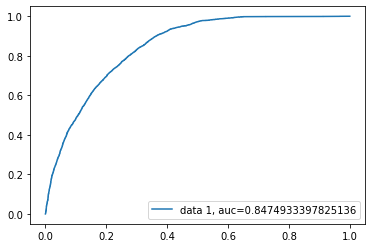

In [39]:
y_pred_proba = pipe_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [40]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [41]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5323


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)


#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#print(clf.score(X_test, y_test))

#Did not use SVC as the large dataset caused a long processing time
#https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

(59998, 29) (59998, 1)
(40000, 29) (40000, 1)


In [43]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_select

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_select

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_select

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_select

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_select

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [44]:
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 24}


Accuracy: 0.546625
Precision: 0.5505777878977629
Recall: 0.4857372438730414


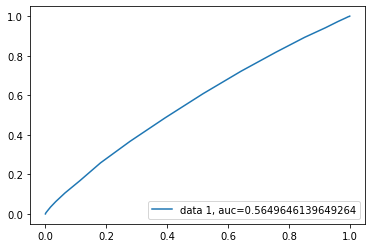

In [45]:
y_pred=knn_gs.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


y_pred_proba = knn_gs.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [46]:
from sklearn.ensemble import RandomForestClassifier
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)

C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mjone\Anaconda3\envs\Python8010\lib\site-packages\sklearn\model_selection

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 200]})

In [47]:
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 50}


Accuracy: 1.0
Precision: 1.0
Recall: 1.0


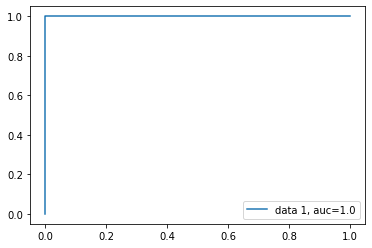

In [48]:
y_pred=rf_gs.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


y_pred_proba = rf_gs.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [49]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(pipe_lr.score(X_test, y_test)))

knn: 0.546625
rf: 1.0
log_reg: 0.7424


### Explain pros and cons in each of your models; explain your evaluation results from training and test dataset and which model you would recommend.
### This is not a coding task but use your writing skills.

-- 20 points

#### Put your writing in Markdown :

I selected a model based on guidance from scikit-learn:https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

Initially my prefered models were logistic regression and SVC. The SVC ran for over an hour when fitting on my machine. Based on run time I decided to try random forest and knn models.

Results Explanation:
KNN accuracy is .55 which is successful a little above half the time. Since scaling is required for this model type I scaled the data to prevent the model being heavily influenced by features that have higher magintudes. For example Clicks for entire session versus whether or not the user clicked on a popular item. I did complete the best practices during data preprocessing of normalization and confirming there were no missing values. The only way to improve the model would like be to develop different features. Potential based on frequency of purchases in the buy table and compare that to the click table. 

RFF- From my research I found that Random Forest Classifier is regarded as a highly accurate model method since it takes the average across the decision tree. Additionally it should prevent overfitting since it is based on averages. Since the provided accuracy is 1 I did have some concern about overfitting. However since I took the time to normalize the numerical data to prevent the model from being swayed heavily by larger variables. 

Logistic Regression - This model was the quickest and easiest to compute. While scaling is not required my model does include scaled features so the comparisons to the other models would be consistent. Since there was some correlation between my variables the model performed well. 

Recommendation: Logistic Regression it has a strong accuracy rating and it has the common application in business. It would be easier to convey to clients over Random Forest. Since Random Forrest uses multiple decision trees communicating that in a business setting would be best for tech driven sectors. 